Dataset is taken from : https://www.kaggle.com/sizlingdhairya1/leaf-disease

In [1]:
#importing libraries required for the project
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf 
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
datadir = "D:/MachineLearning/LeafDisease/data/"
labels = os.listdir(datadir)
IMG_SIZE = 100

In [3]:
labels

['Bacteria', 'Fungi', 'Nematodes', 'Normal', 'Virus']

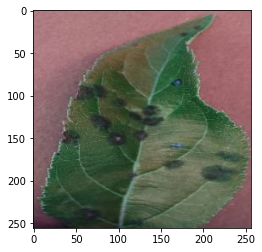

In [4]:
for label in labels:
    path = os.path.join(datadir,label)
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break 
    break 

The below function will fetch images from the directory and convert them to arrays

In [5]:
training_data = []

def create_training_data():
    for label in labels:
        path = os.path.join(datadir,label)
        class_num = labels.index(label) 
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [6]:
create_training_data()

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 667.12it/s]


In [7]:
training_data[:1]

[[array([[[174, 123, 130],
          [174, 123, 130],
          [176, 125, 131],
          ...,
          [173, 117, 122],
          [174, 118, 123],
          [172, 116, 121]],
  
         [[176, 125, 132],
          [176, 125, 132],
          [170, 119, 126],
          ...,
          [174, 118, 123],
          [174, 117, 122],
          [174, 118, 123]],
  
         [[173, 122, 129],
          [170, 119, 126],
          [176, 125, 132],
          ...,
          [176, 120, 125],
          [173, 117, 122],
          [175, 119, 124]],
  
         ...,
  
         [[ 69,  37,  54],
          [ 70,  37,  54],
          [ 72,  39,  55],
          ...,
          [116,  77,  85],
          [118,  79,  87],
          [123,  84,  92]],
  
         [[ 61,  34,  50],
          [ 61,  34,  50],
          [ 61,  34,  50],
          ...,
          [114,  77,  85],
          [115,  78,  86],
          [119,  82,  90]],
  
         [[ 53,  30,  45],
          [ 52,  29,  44],
          [ 51,  28,  43

In [8]:
print(len(training_data))

239


In [9]:
random.shuffle(training_data)

In [10]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [11]:
X.shape

(239, 100, 100, 3)

In [12]:
y = np.array(y)

In [13]:
y.shape

(239,)

The performance of a model often improves with the amount of data that has been used to train it. Data Augmentation artificially increases the size of the training set by generating new variant of each training instance. As data provided to us is not sufficient we could perform data augmentation.

In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [15]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=X.shape[1:]))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128,activation="relu",kernel_initializer="he_uniform"))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
____

In [16]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

In [18]:
X_train = X_train/255
X_test = X_test/255

In [19]:
y_train=keras.utils.to_categorical(y_train,10)
y_test=keras.utils.to_categorical(y_test,10)

In [20]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [21]:
history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),
                               validation_data=(X_test, y_test),epochs=50, verbose=1)

Epoch 1/50
6/6 [==============================] - 3s 485ms/step - loss: 3.8518 - acc: 0.1675 - val_loss: 1.7354 - val_acc: 0.3125
Epoch 2/50
6/6 [==============================] - 3s 493ms/step - loss: 1.8631 - acc: 0.1990 - val_loss: 1.6443 - val_acc: 0.2917
Epoch 3/50
6/6 [==============================] - 3s 507ms/step - loss: 1.7329 - acc: 0.2670 - val_loss: 1.5902 - val_acc: 0.2292
Epoch 4/50
6/6 [==============================] - 3s 495ms/step - loss: 1.6425 - acc: 0.3037 - val_loss: 1.4330 - val_acc: 0.3750
Epoch 5/50
6/6 [==============================] - 3s 517ms/step - loss: 1.5527 - acc: 0.3665 - val_loss: 1.3331 - val_acc: 0.4167
Epoch 6/50
6/6 [==============================] - 3s 517ms/step - loss: 1.4480 - acc: 0.4503 - val_loss: 1.0549 - val_acc: 0.7292
Epoch 7/50
6/6 [==============================] - 3s 499ms/step - loss: 1.3786 - acc: 0.4450 - val_loss: 1.1647 - val_acc: 0.5417
Epoch 8/50
6/6 [==============================] - 3s 503ms/step - loss: 1.2924 - acc: 0.46

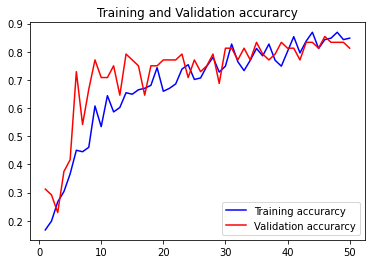

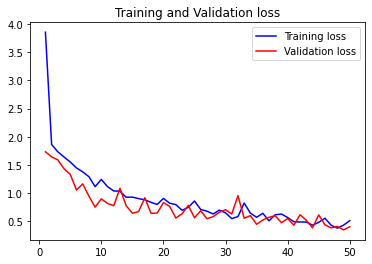

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [23]:
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

48/48 [==============================] - 0s 5ms/sample - loss: 0.4061 - acc: 0.8125
Test Accuracy: 81.25


In [24]:
model.save('leaf_disease.h5')

In [25]:
classifierLoad = tf.keras.models.load_model('leaf_disease.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
pic = cv2.imread('test3.jpg')
pic = cv2.resize(pic,(100,100))
pic = np.reshape(pic,[1,100,100,3])
y_prob = classifierLoad.predict(pic) 
y_classes = y_prob.argmax(axis=-1)
print(y_classes)

[4]
